# Handwritten Digits Classifier Using Neural Network

# Indices
&nbsp;1. Dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1. Loading Data<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2. Data Preprocessing<br>
&nbsp;2. Model - Neural Network<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1. Supporting Functions<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.1. Activation Functions<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.2. Gradient of Activation Functions<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.3. Processing Functions<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2. Model: Classifier Class<br>
&nbsp;3. Loading Model<br>
&nbsp;4. Evaluation<br>

# Importing Libraries

In [1]:
import numpy as np
import pickle
import os
import re  # regex
import matplotlib.pyplot as plt
from IPython import display
from struct import unpack
from datetime import datetime

# Defining Constants

In [2]:
# list of colors for plotting
COLOR_LIST = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#58e03d']

# 1. Dataset
MNIST handwritten digits dataset: http://yann.lecun.com/exdb/mnist/

In [3]:
NUM_TRAIN_MAX = 60000  # number of examples in the MNIST training set
NUM_TEST_MAX = 10000   # number of examples in the MNIST test set
IMG_SIZE = 28          # each image has size of 28x28
INP_LENGTH = 784       # size of image after straightened up
NUM_CLASS = 10         # number of classes to make prediction on

num_train_load = 60000  # number of training examples to load
num_test_load = 10000   # number of test examples to load

## 1.1. Loading Data

In [6]:
def load_images(set_type, num_example=None):
    """
    Load images of handwritten digits
    :param str set_type: train/test
    :param int num_example: number of images to read
    :return: matrix of images, each image is a vector of ints in [0, 255]
    :rtype: np_array<int>[num_example, INP_LENGTH]
    """
    
    # get set to load from
    if set_type == "train":
        file_name = "datasets/train-images.idx3-ubyte"
        if num_example is None: num_example = NUM_TRAIN_MAX  # read all
    else:
        file_name = "datasets/t10k-images.idx3-ubyte"
        if num_example is None: num_example = NUM_TEST_MAX  # read all

    # load images from file
    with open(file_name, "rb") as fi:

        # these numbers are not used and are assigned manually
        fi.read(4)  # magic number, not used
        fi.read(4)  # num_row - number of images
        fi.read(4)  # size - number of rows
        fi.read(4)  # size - number of columns
        
        # load each image from binary data
        image_list = []
        for i in range(num_example):
            image = []
            for pi in range(INP_LENGTH):
                pixel = unpack('B', fi.read(1))[0]
                image.append(pixel)
            image_list.append(image)

    return np.array(image_list)


def load_labels(set_type, num_example=None):
    """
    Load labels of images
    :param str set_type: train/test
    :param int num_example: number of labels to read
    :return: vector of labels, each label is an int in [0, 9]
    :rtype: np_array<int>[num_example,]
    """

    # get set to load from
    if set_type == "train":
        file_name = "datasets/train-labels.idx1-ubyte"
        if num_example is None: num_example = NUM_TRAIN_MAX  # read all
    else:
        file_name = "datasets/t10k-labels.idx1-ubyte"
        if num_example is None: num_example = NUM_TEST_MAX  # read all

    # load labels from file
    with open(file_name, "rb") as fi:

        # these numbers are not used and are assigned manually
        fi.read(4)  # magic number, not used
        fi.read(4)  # num_row - number of labels

        # load each label from binary data
        label_list = []
        for i in range(num_example):
            label = unpack('B', fi.read(1))[0]
            label_list.append(label)

    return np.array(label_list)


def load_data_set(set_type, num_example=None):
    """
    Load images and labels
    :param str set_type: train/test
    :param int num_example: number of examples to read
    :return: images list, labels list
    :rtype: np_array<int>[num_example, INP_LENGTH], np_array<int>[num_example,]
    """
    
    return load_images(set_type, num_example=num_example), load_labels(set_type, num_example=num_example)

In [7]:
train_x, train_y = load_data_set('train', num_example=num_train_load)
test_x, test_y = load_data_set('test', num_example=num_test_load)

## 1.2. Data Preprocessing

In [8]:
def scale_x(data_x):
    """
    Apply feature scaling for input set so that each pixel falls in range [-1, 1]
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :return: input set after scaled
    :rtype: np_array<int>[n, INP_LENGTH]
    """
    
    return (data_x/255)*2 - 1

In [9]:
train_x = scale_x(train_x)
test_x = scale_x(test_x)

# 2. Model - Neural Network

## 2.1. Supporting Functions

### 2.1.1. Activation Functions

Sigmoid:

\begin{equation}
S(x) = \frac{1}{1+e^{-x}}
\end{equation}

\begin{equation}
S(z)_i = \frac{1}{1+e^{-z_i}}
\end{equation}

Softmax:

\begin{equation}
\sigma(z)_i = \frac{e^{z_i}}{\sum^n_{j=1}e^{z_j}}
\end{equation}

In [10]:
def sigmoid(z):
    """
    Sigmoid activation function
    :param np_array<float>[1, n] z: output of a layer that has not been activated 
    :return: activated output
    :rtype: np_array<float>[1, n]
    """

    return 1/(1+np.exp(-z))


def softmax(z):
    """
    Softmax activation function
    :param np_array<float>[1, n] z: output of a layer that has not been activated 
    :return: activated output
    :rtype: np_array<float>[1, n]
    """
    
    exp_arr = np.exp(z)
    sum = np.sum(exp_arr)
    return exp_arr/sum

### 2.1.2. Derivative of Activation Functions

Derivative of Sigmoid:

\begin{equation}
S'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = S(x)(1-S(x))
\end{equation}

\begin{equation}
S'(a)_i = \frac{e^{-a_i}}{(1+e^{-a_i})^2} = S(a_i)(1-S(a_i))
\end{equation}

In [11]:
def sigmoid_derv(a):
    """
    Derivative of sigmoid activation function
    :param np_array<float>[1, n] a: output of a layer that has been activated 
    :return: derivative of softmax activation function
    :rtype: np_array<float>[1, n]
    """
    
    return np.multiply(a, 1-a)

### 2.1.3. Processing Functions
One-hot encoder:<br>
0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]<br>
9 => [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [12]:
def make_one_hot(y):
    """
    Make one-hot encoder array from label
    :param int y: a single label
    :return: one-hot encoder array
    :rtype: np_array<int>[NUM_CLASS,]
    """
    
    one_hot = np.zeros(NUM_CLASS)
    one_hot[y] = 1
    return one_hot

## 2.2. Model: Classifier Class

Feed-forward:

\begin{align}
z^{(l)} & = \big(bias+a^{(l-1)}\big).W^{(l-1)} \\
a^{(l)} & = activation^{(l)}\big(z^{(l)}\big) \\\\
a^{(0)} & = x = \text{input} \\
z^{(1)} & = \big([1]+a^{(0)}\big).W^{(0)} \\
a^{(1)} & = S\big(z^{(1)}\big) = \text{hidden layer} \\
z^{(2)} & = \big([1]+a^{(1)}\big).W^{(1)} \\
a^{(2)} & = \sigma\big(z^{(2)}\big) = \hat{y} = \text{output}
\end{align}

Loss function: Cross-entropy

\begin{align}
J(W) & = -\sum_{k=0}^{9} y_k \log\hat{y}_k \tag{for one example} \\
J(W) & = -\frac{1}{n}\sum_{i=0}^{n-1}\sum_{k=0}^{9} y^{(i)}_k \log\hat{y}^{(i)}_k \tag{for the entire dataset}
\end{align}

Backpropagation:

\begin{eqnarray}
\delta^{(L)} &=& \frac{\partial J}{\partial z^{(L)}} = \frac{\partial J}{\partial a^{(L)}}\frac{\partial a^{(L)}}{\partial z^{(L)}} &=& a^{(L)}-y \\
\delta^{(l)} &=& \frac{\partial J}{\partial z^{(l)}} = \bigg(\frac{\partial J}{\partial z^{(l+1)}}W^{(l)T}\bigg)\frac{\partial a^{(l)}}{\partial z^{(l)}} &=& \bigg(\delta^{(l+1)}W^{(l)T}\bigg)\frac{\partial activation^{(l)}\big(z^{(l)}\big)}{\partial z^{(l)}} \\
\frac{\partial J}{\partial W^{(l)}} &=& \big(bias+a^{(l)T}\big)\frac{\partial J}{\partial z^{(l+1)}} &=& \big(bias+a^{(l)T}\big)\delta^{(l+1)} \\
\end{eqnarray}
<br>
<br>
\begin{align}
\delta^{(2)} & = a^{(2)}-y = \hat{y}-y = output-y \\
\frac{\partial J}{\partial W^{(1)}} & = \big([1]+a^{(1)T}\big)\delta^{(2)} \\
\delta^{(1)} & = \big(\delta^{(2)}W^{(1)T}\big)\frac{\partial S\big(z^{(1)}\big)}{\partial z^{(1)}} \\
\frac{\partial J}{\partial W^{(0)}} & = \big([1]+a^{(0)T}\big)\delta^{(1)}
\end{align}

Update weights:

\begin{equation}
W^{(i)} = W^{(i)} - \alpha\frac{\partial J}{\partial W^{(i)}}
\end{equation}

In [13]:
class HDClassifierNN:
    """
    Handwritten digits classifier using Neural Network model
    Layers: [INPUT_LENGTH, 100, 10]
    Learning rate: 0.01
    Loss function: Cross-entropy
    Optimization method: Stochastic Gradient Descent
    """
    
    def __init__(self):
        """
        Initialize model
        :return: None
        """
        
        # set layers, learning rate & other attributes
        self.layer_list = [INP_LENGTH, 100, 10]
        self.learning_rate = 0.01
        self.w_list = []
        self.trained_epochs = 0
        self.loss_list = [[], []]
        
        # random weights in range [-1, 1)
        for i in range(len(self.layer_list) - 1):
            self.w_list.append(np.random.rand(self.layer_list[i]+1, self.layer_list[i+1])*2-1)
            
            
    def predict(self, x):
        """
        Give posibility for each class
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: list of posibility for each class
        :rtype: np_array<float>[1, NUM_CLASS]
        """
        
        # input layer
        a = x
        
        # hidden layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[0])  # get output from layer
        a = sigmoid(z)                    # apply activation function
        
        # output layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[1])  # get output from layer
        a = softmax(z)                    # apply activation function
        
        return a
    
    
    def predict_class(self, x):
        """
        Give predicted class and certainty on the prediction
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: predicted_class, certainty
        :rtype: int, float
        """
        
        prediction = self.predict(x)[0]
        certainty = np.amax(prediction)
        predicted_class = np.where(prediction == certainty)[0][0]
        return predicted_class, certainty
            
    
    def feed_forward(self, x):
        """
        Perform feed-forward for neural network
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: list of outputs for every layers, including x
        :rtype: list<np_array<float>[1, length_of_each_layer]>[number_of_layers]
        """
        
        # input layer
        a = x
        output_list = [a]                 # add input to output_list
        
        # hidden layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[0])  # get output from layer
        a = sigmoid(z)                    # apply activation function
        output_list.append(a)             # add output of the layer to output_list
        
        # output layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[1])  # get output from layer
        a = softmax(z)                    # apply activation function
        output_list.append(a)             # add output of the layer to output_list

        return output_list
        
    
    def cal_loss(self, prediction, label):
        """
        Calculate cross-entropy loss for a single prediction
        :param np_array<float>[1, NUM_CLASS] prediction:
            prediction returned by self.predict() or self.feed_forward()[-1]
        :param int label: label
        :return: loss for the single prediction
        :rtype: float
        """

        return -np.log(prediction[0][label])
    
    
    def cal_loss_set(self, data_x, data_y):
        """
        Calculate cross-entropy loss when predicting on inputted set
        :param np_array<int>[n, INP_LENGTH] data_x: input set
        :param np_array<int>[n,] data_y: label set
        :return: loss on the inputted set
        :rtype: float
        """
        
        total_loss = 0
        # calculate loss for each prediction then add to total_loss
        for i in range(len(data_y)):
            prediction = self.predict(data_x[i].reshape(1, 784))
            total_loss += self.cal_loss(prediction, data_y[i])
        loss = total_loss / len(data_y)  # loss is average loss of a prediction
        return loss
    
    
    def backpropagate(self, output_list, label):
        """
        Perform backpropagation for neural network
        :param list<np_array<float>[1, length_of_each_layer]>[number_of_layers] output_list:
            list of outputs for every layers, including input layer, returned by self.feed_forward()
        :param int label: label
        :return: list of derivatives for updating weights
        :rtype: list<np_array<float>[length_of_layer[i]+1, length_of_layer[i+1]]>[number_of_layers-1]
        """
        
        # output layer
        delta = output_list[-1] - make_one_hot(label)                         # get "error" of the output layer
        derv = np.matmul(np.append([[1]], output_list[-2].T, axis=0), delta)  # get derivative
        derv_list = [derv]                                                    # add derivative to derv_list
        
        # hidden layer
        activation_derv = sigmoid_derv(output_list[-2])                         # get derivative of the activation function
        delta = np.multiply(np.matmul(delta, self.w_list[-1][1: , : ].T), activation_derv)  # get "error" of the layer
        derv = np.matmul(np.append([[1]], output_list[-3].T, axis=0), delta)                # get derivative of loss function
        derv_list.insert(0, derv)                                                           # add derivative to grad_list
        
        return derv_list
    
    
    def update_weights(self, derv_list):
        """
        Update weights to minimize loss function
        :param list<np_array<float>[length_of_layer[i]+1, length_of_layer[i+1]]>[number_of_layers-1] derv_list:
            list of derivatives for updating weights, returned by self.backpropagate()
        :return: None
        """
        
        for i in range(len(self.w_list)):
            self.w_list[i] = self.w_list[i] - self.learning_rate*derv_list[i]
    
    
    def plot_losses(self, num_point_x=None, start_time=None):
        """
        Plot loss history on training and test set
        :param datetime.datetime start_time: time when starting training
        :return: None
        """
        
        fig = plt.figure(figsize=(16, 5))
        ax = plt.subplot(xlabel='100 examples', ylabel='Loss', title='Losses', xlim=(0, len(self.loss_list[0])), ylim=(0, 5))
        ax.plot(self.loss_list[0], label='Train | {0:.2f}'.format(self.loss_list[0][-1]))
        ax.plot(self.loss_list[1], label='Test | {0:.2f}'.format(self.loss_list[1][-1]))
        if start_time is not None:
            ax.text(0, -0.7, 'Time elapsed: {}'.format(datetime.utcnow()-start_time))
        ax.legend()

# 3. Loading Model
Load trained model from file.

In [4]:
def load_model(name=None):
    """
    Load model from saved-models directory
    :param str name: name of the model, load most recent model with timestamp in name if not specified
    :return: loaded model
    :rtype: HDClassifierNN
    """
    
    # if name not specified: get the most recent model with timestamp in name
    if name is None:
        name = ''
        for r, d, f in os.walk('saved-models'):
            for file_name in f:
                if re.search('model-\d{10}\.pickle', file_name) is not None and file_name > name:
                    name = file_name
        if name == '':
            print("No model with timestamp found")
            return None
    # else: get model with name 'model-name.pickle'
    else:
        name = 'model-{}.pickle'.format(name)
    
    # load model from pickle file
    with open('saved-models/{}'.format(name), 'rb') as fi:
        model = pickle.load(fi)
    print("Model loaded from {}".format(name))
              
    return model

In [24]:
model = load_model('3-60000-10000')  # the name means trained with 3 epoch,
                                     # on 60000 training examples
                                     # and tested on 10000 examples

Model loaded from model-3-60000-10000.pickle


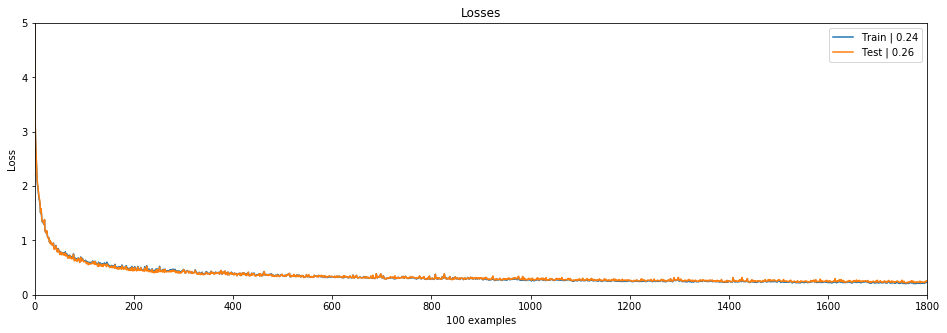

In [25]:
model.plot_losses()

# 4. Evaluation

In [28]:
def cal_accuracy(model, data_x, data_y):
    """
    Calculate accuracy score of model on inputted set 
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :param np_array<int>[n,] data_y: label set
    :return: accuracy score
    :rtype: float
    """
    
    correct_count = 0
    for i in range(len(data_y)):
        predicted_class, _ = model.predict_class(data_x[i].reshape(1, 784))
        correct_count += predicted_class == data_y[i]
    return correct_count / len(data_y)

Accuracy on training set: 92.84666666666666%
Accuracy on test set: 92.42%


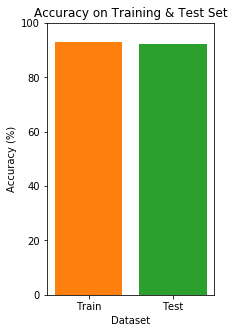

In [31]:
acc_train = cal_accuracy(model, train_x, train_y)*100
acc_test = cal_accuracy(model, test_x, test_y)*100

print("Accuracy on training set: {}%".format(acc_train))
print("Accuracy on test set: {}%".format(acc_test))

# END